In [5]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.decomposition import PCA, TruncatedSVD

# Load and Preprocess Data
Filter our users based on total play count and drop unnecessary columns.


In [6]:
user_df = pd.read_csv("../data/filtered_user_df.csv")
user_df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)


In [7]:
user_df.head()

,user,artist_name,play_count,artist_url
0,nyancrimew,Jasmine Thompson,7559.0,https://www.last.fm/music/Jasmine+Thompson
1,nyancrimew,Eminem,5851.0,https://www.last.fm/music/Eminem
2,nyancrimew,Watsky,3044.0,https://www.last.fm/music/Watsky
3,nyancrimew,Linkin Park,2938.0,https://www.last.fm/music/Linkin+Park
4,nyancrimew,twenty one pilots,1849.0,https://www.last.fm/music/twenty+one+pilots


In [8]:
# Getting total play counts for users and filtered some out 

user_total_play = (
    user_df.groupby("user")["play_count"]
    .sum()
    .reset_index(name="total_play_count")
)
filtered_users = user_total_play[
    user_total_play["total_play_count"] >= 125000
]["user"]
filtered_df = user_df[user_df["user"].isin(filtered_users)]


In [9]:
filtered_df.head()

,user,artist_name,play_count,artist_url
1259,ext_beck,Linkin Park,51318.0,https://www.last.fm/music/Linkin+Park
1260,ext_beck,Coldplay,21753.0,https://www.last.fm/music/Coldplay
1261,ext_beck,Moby,17404.0,https://www.last.fm/music/Moby
1262,ext_beck,Avril Lavigne,11340.0,https://www.last.fm/music/Avril+Lavigne
1263,ext_beck,Muse,8118.0,https://www.last.fm/music/Muse


Convert this to a sparse matrix. Start by mapping users and artists to a unique numeric value.

In [10]:
user_ids = filtered_df["user"].unique()
artist_names = filtered_df["artist_name"].unique()

user_to_idx = {user: i for i, user in enumerate(user_ids)}
artist_to_idx = {artist: j for j, artist in enumerate(artist_names)}

# Convert rows to (row index, column index, value) tuples
rows = filtered_df["user"].map(user_to_idx)
cols = filtered_df["artist_name"].map(artist_to_idx)
values = filtered_df["play_count"]
sparse_matrix = sparse.coo_matrix(
    (values, (rows, cols)), shape=(len(user_ids), len(artist_names))
)


In [11]:
# View sparse matrix
dense_matrix = sparse_matrix.todense()

row, col, data = sparse.find(sparse_matrix)

for r, c, d in zip(row[:10], col[:10], data[:10]):
    print(f"User index: {r}, Artist index: {c}, Play count: {d}")


User index: 0, Artist index: 0, Play count: 51318.0
User index: 9, Artist index: 0, Play count: 4238.0
User index: 11, Artist index: 0, Play count: 4734.0
User index: 13, Artist index: 0, Play count: 4710.0
User index: 18, Artist index: 0, Play count: 2882.0
User index: 19, Artist index: 0, Play count: 4456.0
User index: 26, Artist index: 0, Play count: 3284.0
User index: 28, Artist index: 0, Play count: 7427.0
User index: 30, Artist index: 0, Play count: 1901.0
User index: 36, Artist index: 0, Play count: 1948.0


# Collabroative Filtering
Use `TruncatedSVD`.

**Collaborative Filtering**: Assumption is that if users $A$ and $B$ rate items similarly, $A$ is more likely to have $B$'s opinion on an item (artist) than that of another randomly chosen user.

Use **SVD** to decompose the original sparse matrix (users' interactions with items, i.e., play counts) into lower-dimensional matrices, capturing latent factors with users and items.

In [12]:
num_components = 50  # Number of latent factors to represent users and items

# Matrix factorization with TruncatedSVD
svd = TruncatedSVD(n_components=num_components, random_state=42)

user_features = svd.fit_transform(
    sparse_matrix
)  # Represent the users in the reduced latent factor space.
item_features = svd.components_


In [17]:
item_features.shape

(50, 9478)

## Visualize Artist Latent Features with PCA

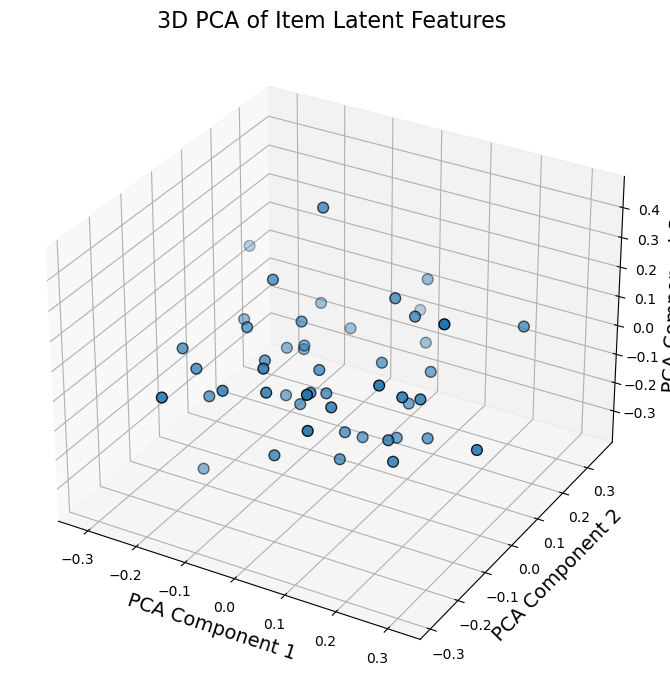

In [9]:
def visualize_latent_features(
    _item_features: np.ndarray, item_labels: list[int] = None
) -> None:
    pca = PCA(n_components=3)
    reduced_features = pca.fit_transform(_item_features)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    if item_labels is not None:
        for i, label in enumerate(item_labels):
            ax.scatter(
                reduced_features[i, 0],
                reduced_features[i, 1],
                reduced_features[i, 2],
                label=label,
                edgecolor="k",
                s=60,
            )
        ax.legend(fontsize="small", loc="best")
    else:
        ax.scatter(
            reduced_features[:, 0],
            reduced_features[:, 1],
            reduced_features[:, 2],
            edgecolor="k",
            s=60,
        )

    ax.set_xlabel("PCA Component 1", fontsize=14)
    ax.set_ylabel("PCA Component 2", fontsize=14)
    ax.set_zlabel("PCA Component 3", fontsize=14)
    ax.set_title("3D PCA of Item Latent Features", fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_latent_features(item_features)


In [2]:
idx_to_artist = {idx: artist for artist, idx in artist_to_idx.items()}


def recommend_artists(
    _user_id: int,
    _user_features: np.ndarray,
    _item_features: np.ndarray,
    top_n: int = 5,
) -> list[str]:
    # Predicted rating is the dot product of `user_factors` and `item_factors`. Will be the same shape as the original matrix, and the element will represent the predicted interaction (play count) with an artist.
    predicted_ratings = np.dot(_user_features, _item_features)
    user_ratings = predicted_ratings[_user_id, :]
    recommended_item_idx = np.argsort(user_ratings)[::-1][:top_n]
    recommended_artist_names = [
        idx_to_artist[idx] for idx in recommended_item_idx
    ]
    return recommended_artist_names


NameError: name 'artist_to_idx' is not defined

In [3]:
# Example
idx_to_user = {idx: user for user, idx in user_to_idx.items()}


def recommend_for_user(user_id: int, top_n: int) -> None:
    recommended_artists = recommend_artists(
        user_id, user_features, item_features, top_n
    )
    username = idx_to_user[user_id]
    print(f"Recommended artists for user {username}: {recommended_artists}")


recommend_for_user(0, 10)


NameError: name 'user_to_idx' is not defined

# Extra Analysis

## Recommendation Frequency

In [12]:
sample_user_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

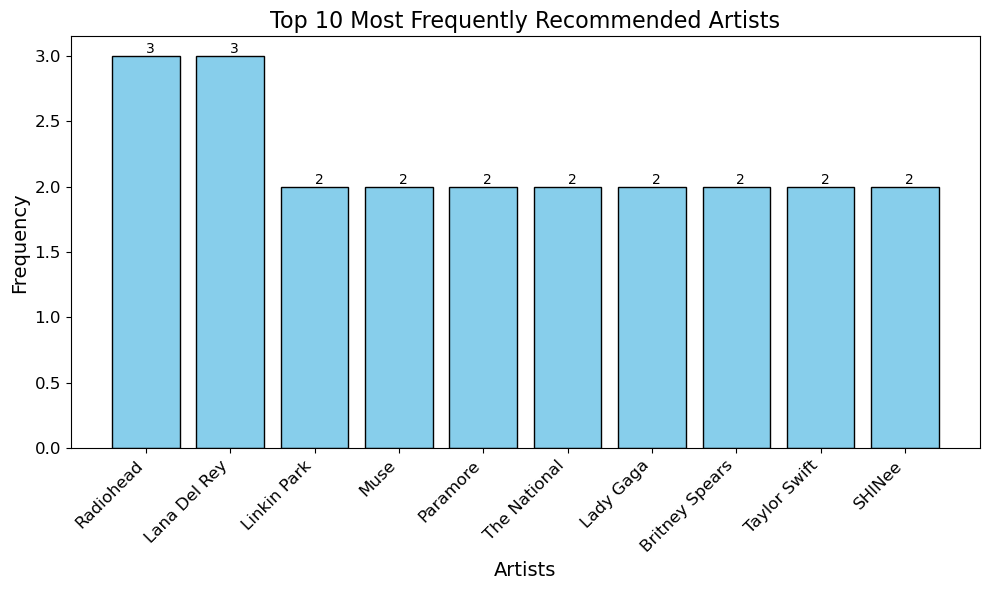

In [13]:
def analyze_recommendation_frequency(
    user_indices: list[int],
    _user_features: np.ndarray,
    _item_features: np.ndarray,
    top_n: int = 5,
) -> None:
    all_recommended_artists = []

    for user_id in user_indices:
        recommended_artists = recommend_artists(
            user_id, _user_features, _item_features, top_n
        )
        all_recommended_artists.extend(recommended_artists)

    artist_freq = Counter(all_recommended_artists)
    sorted_artists = sorted(
        artist_freq.items(), key=lambda x: x[1], reverse=True
    )[:10]

    artists, frequencies = zip(*sorted_artists)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(artists, frequencies, color="skyblue", edgecolor="black")
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Artists", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title("Top 10 Most Frequently Recommended Artists", fontsize=16)

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0, yval, int(yval), va="bottom"
        )

    plt.tight_layout()
    plt.show()


analyze_recommendation_frequency(
    sample_user_indices, user_features, item_features
)

# 50 predictions total: 10 sample users, top 5 predictions for each 


## Diversity of Recommendations

After collecting unique recommendations, calculate the total number of recommendations across all users (maximum possible number of unique recommendations if every recommendation for every user were different).

Calculate the diversity score as the ratio of the number of unique artists to the total number of recommendations. 

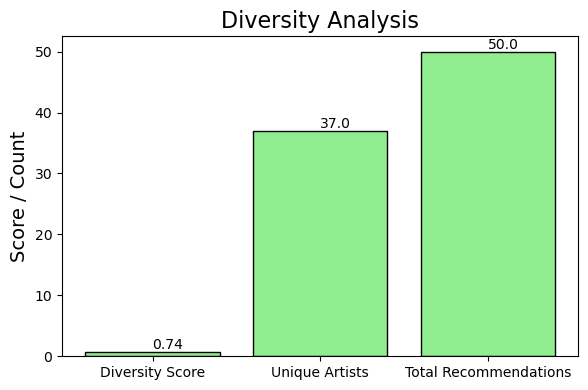

In [14]:
def analyze_diversity(
    user_indices: list[int],
    _user_features: np.ndarray,
    _item_features: np.ndarray,
    top_n: int = 5,
) -> None:
    unique_artists = set()

    for user_id in user_indices:
        recommended_artists = recommend_artists(
            user_id, _user_features, _item_features, top_n
        )
        unique_artists.update(recommended_artists)

    total_recommendations = len(user_indices) * top_n
    diversity_score = len(unique_artists) / total_recommendations

    plt.figure(figsize=(6, 4))
    bars = plt.bar(
        ["Diversity Score", "Unique Artists", "Total Recommendations"],
        [diversity_score, len(unique_artists), total_recommendations],
        color="lightgreen",
        edgecolor="black",
    )
    plt.ylabel("Score / Count", fontsize=14)
    plt.title("Diversity Analysis", fontsize=16)

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval,
            round(yval, 2) if isinstance(yval, float) else int(yval),
            va="bottom",
        )

    plt.tight_layout()
    plt.show()


analyze_diversity(sample_user_indices, user_features, item_features)


## Simulate Satisfaction Across a Set of Users

The satisfaction score is calculated by finding the intersection between the set of recommended artists and the set of interacted artists.

Normalize the satisfaction score by dividing the count of the intersection by `top_n`, the total number of recommendations. This will provide a score between 0 and 1, where a higher score indicates higher satisfaction.

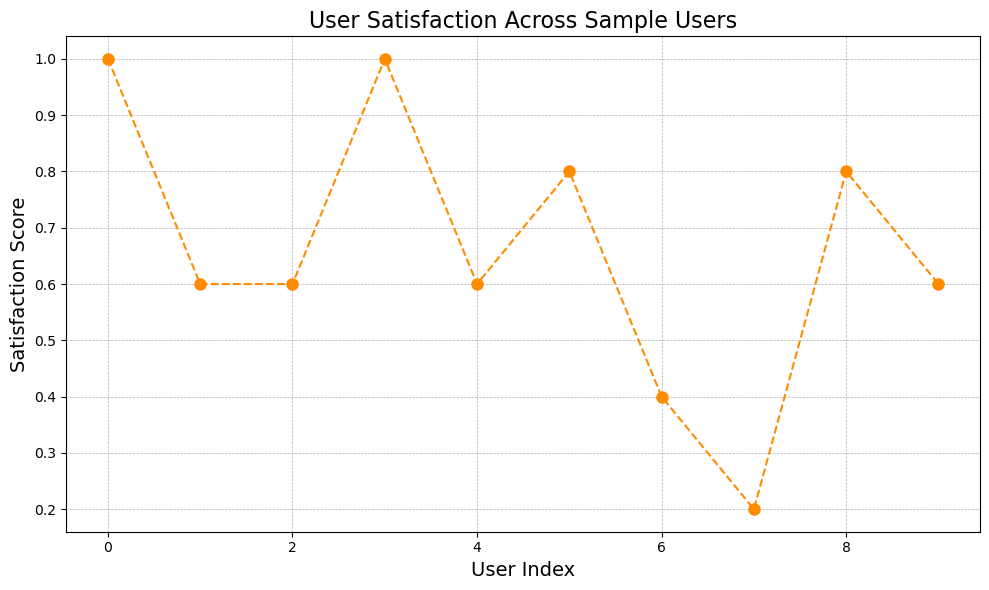

In [15]:
def simulate_user_satisfaction(
    user_indices: list[int],
    _user_features: np.ndarray,
    _item_features: np.ndarray,
    _sparse_matrix: sparse.coo_matrix,
    top_n: int = 5,
) -> None:
    satisfaction_scores = []

    for user_id in user_indices:
        recommended_artists = recommend_artists(
            user_id, _user_features, _item_features, top_n
        )

        # Identify user interactions.
        user_interactions = _sparse_matrix.getrow(user_id).nonzero()[1]
        interacted_artists = [idx_to_artist[idx] for idx in user_interactions]
        satisfaction = set(recommended_artists).intersection(
            set(interacted_artists)
        )
        satisfaction_scores.append(len(satisfaction) / top_n)

    plt.figure(figsize=(10, 6))
    plt.plot(
        user_indices,
        satisfaction_scores,
        marker="o",
        linestyle="--",
        color="darkorange",
        markersize=8,
    )
    plt.xlabel("User Index", fontsize=14)
    plt.ylabel("Satisfaction Score", fontsize=14)
    plt.title("User Satisfaction Across Sample Users", fontsize=16)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


simulate_user_satisfaction(
    sample_user_indices, user_features, item_features, sparse_matrix
)
